In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from textblob import TextBlob
import nltk
import warnings
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn import metrics
import math 
import re
warnings.filterwarnings('ignore')
df_Train=pd.read_csv("/content/sample_data/drugsComTest_raw.csv")
df_Test=pd.read_csv("/content/sample_data/drugsComTest_raw.csv")

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
df_Train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [4]:
df_Train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [5]:
df=pd.concat([df_Train,df_Test])

In [6]:
df.describe()

,uniqueID,rating,usefulCount
count,107532.000000,107532.000000,107532.000000
mean,116386.701187,6.976900,27.989752
std,67017.428260,3.285192,36.172665
min,0.000000,1.000000,0.000000
25%,58272.000000,4.000000,6.000000
50%,116248.500000,8.000000,16.000000
75%,174588.000000,10.000000,36.000000
max,232284.000000,10.000000,949.000000


In [7]:
print(df.isnull().sum())

uniqueID         0
drugName         0
condition      590
review           0
rating           0
date             0
usefulCount      0
dtype: int64


In [8]:
df["condition"].value_counts()

Birth Control                                                19296
Depression                                                    6190
Pain                                                          4200
Anxiety                                                       3816
Acne                                                          3694
                                                             ...  
Head and Neck Cance                                              2
Peripheral Arterial Disease                                      2
Tympanostomy Tube Placement Surgery                              2
Chronic Inflammatory Demyelinating Polyradiculoneuropathy        2
Neutropenia                                                      2
Name: condition, Length: 708, dtype: int64

In [9]:
df=df[df["condition"].str.contains("span")==False]

**Data Visualization**

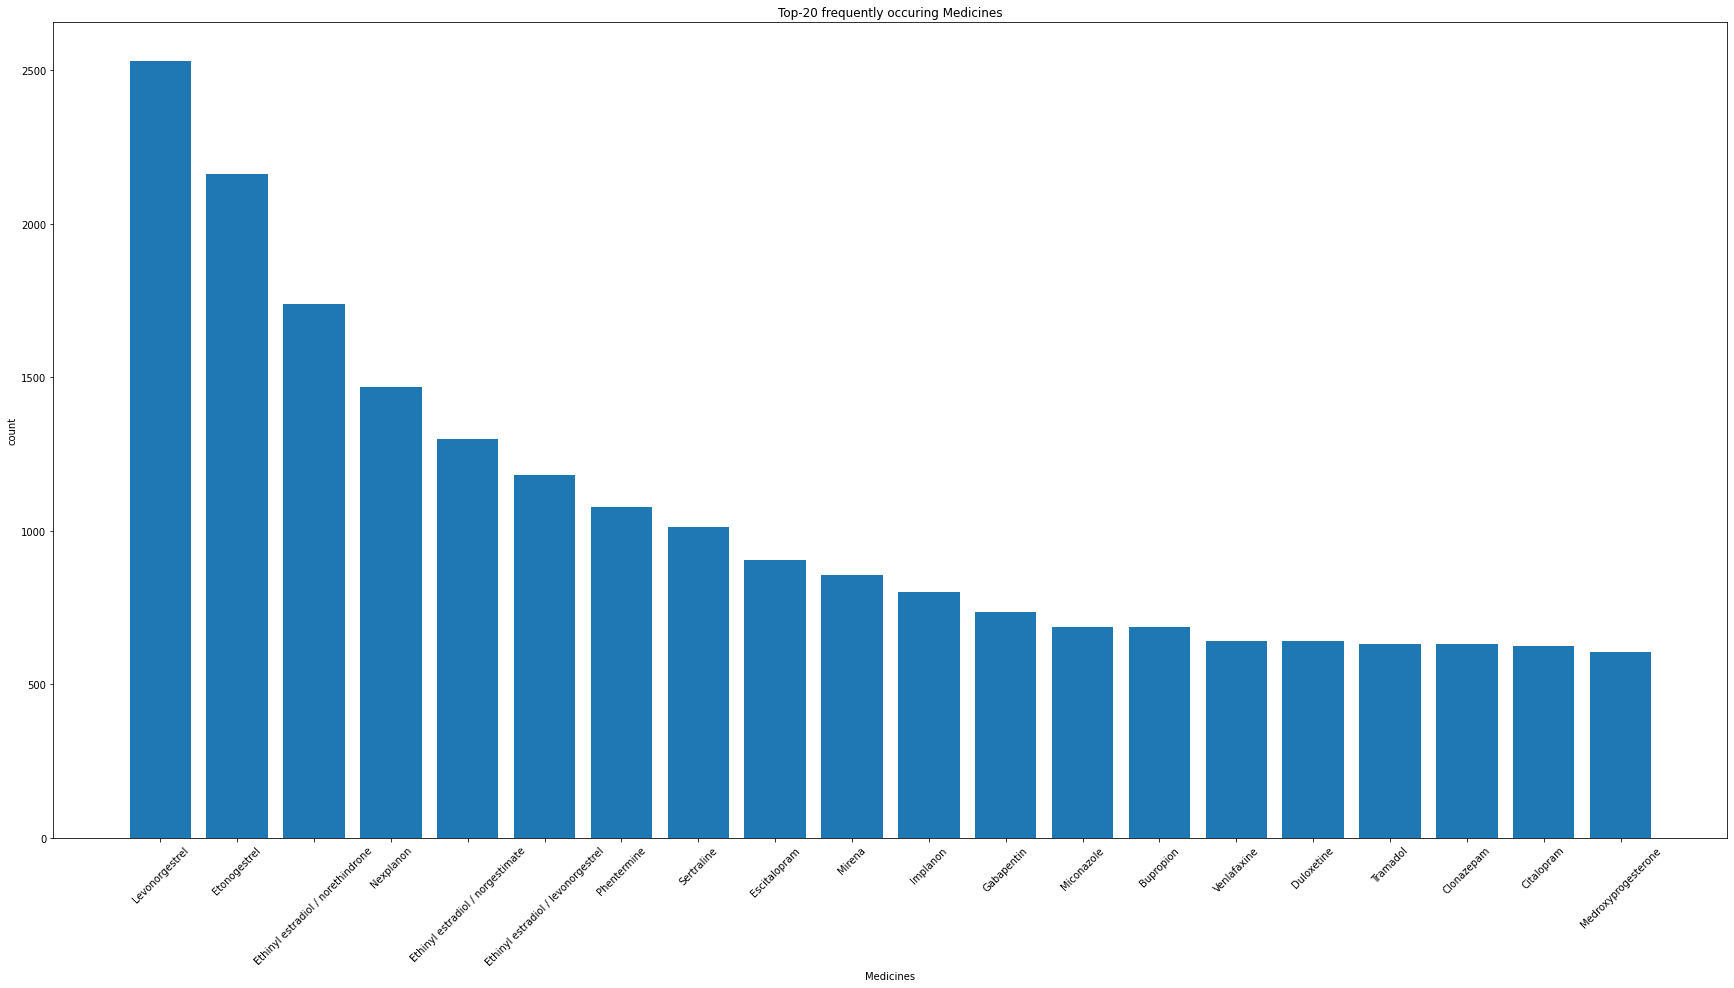

In [10]:
plt.figure(figsize = (30,15))
plt.bar(df["drugName"].value_counts().index[0:20],df["drugName"].value_counts().values[0:20])
plt.title('Top-20 frequently occuring Medicines')
plt.xlabel('Medicines')
plt.xticks(rotation = 45)
plt.ylabel('count')
plt.show()

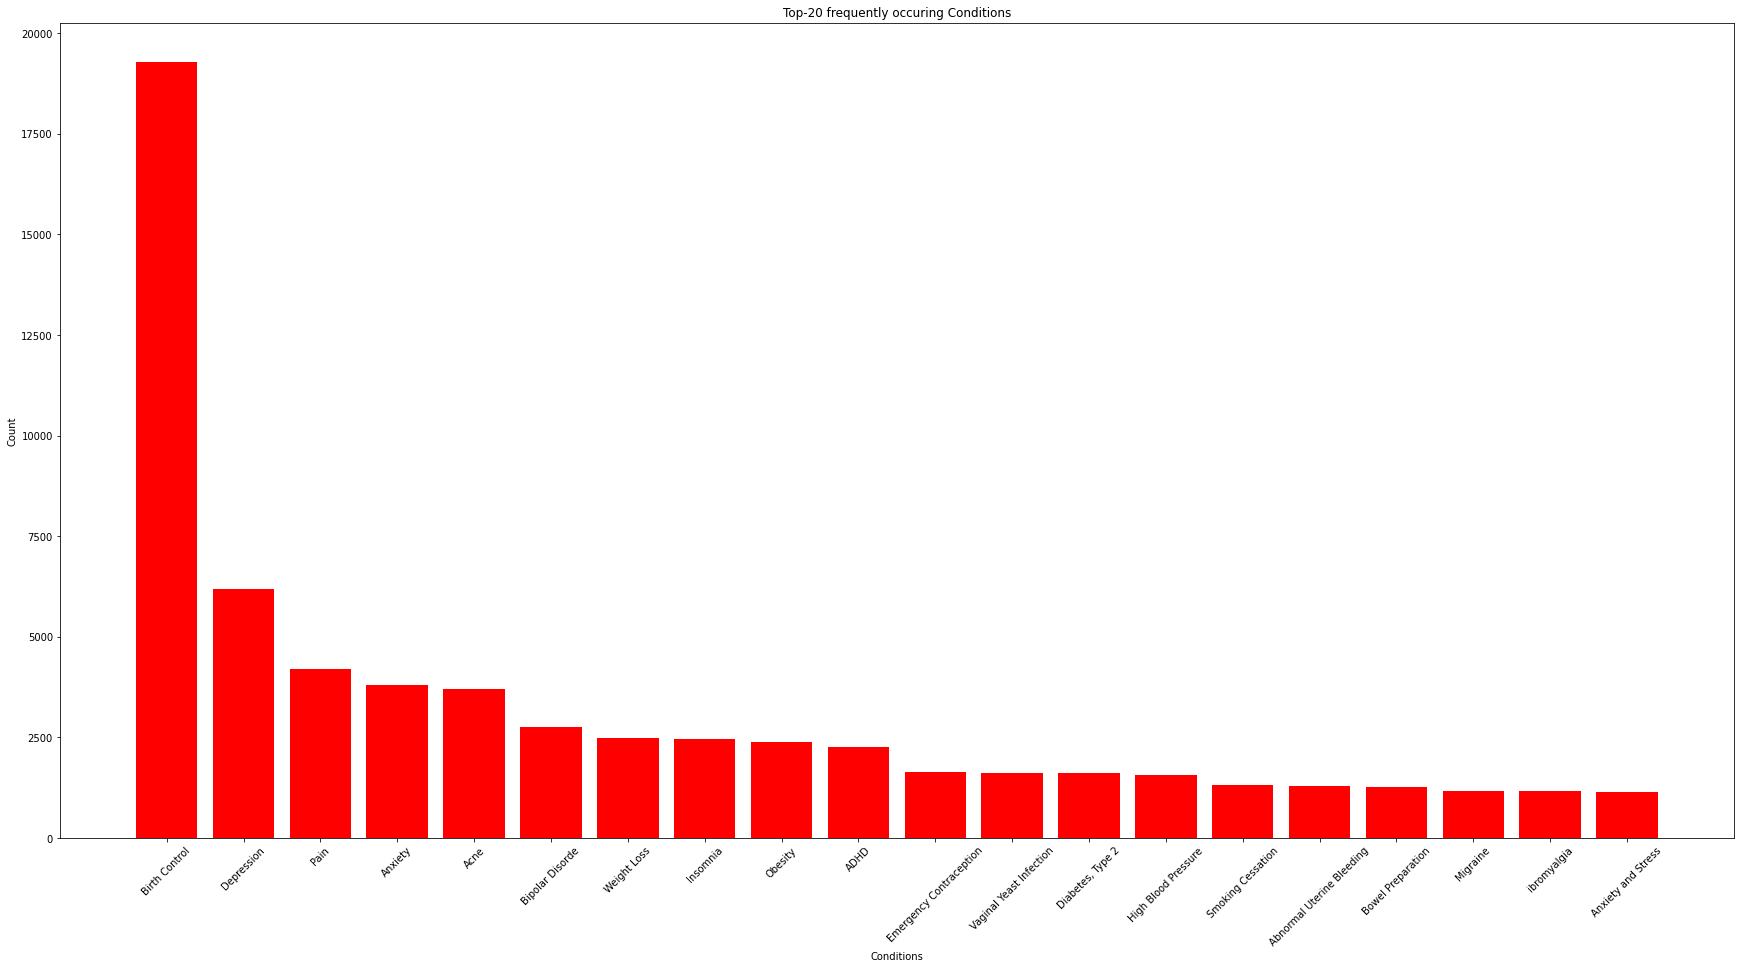

In [11]:
from matplotlib import pyplot as plt
plt.figure(figsize = (30,15))
plt.bar(df["condition"].value_counts().index[0:20],df["condition"].value_counts().values[0:20],color='red')
plt.title('Top-20 frequently occuring Conditions')
plt.xlabel('Conditions')
plt.xticks(rotation = 45)
plt.ylabel('Count')
plt.show()

In [12]:
# converting the date into datetime format
df['date'] = pd.to_datetime(df['date'], errors = 'coerce')

# now extracting year from date
df['Year'] = df['date'].dt.year

# extracting the month from the date
df['month'] = df['date'].dt.month

# extracting the days from the date
df['day'] = df['date'].dt.day

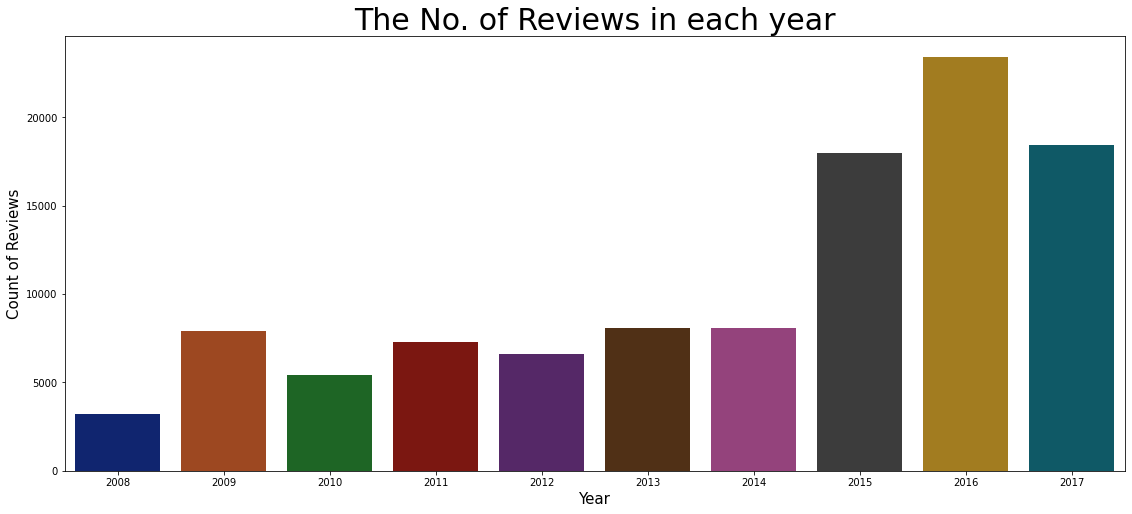

In [13]:
# looking at the no. of reviews in each of the year

plt.rcParams['figure.figsize'] = (19, 8)
sns.countplot(df['Year'], palette ='dark')
plt.title('The No. of Reviews in each year', fontsize = 30)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Count of Reviews', fontsize = 15)
plt.show()

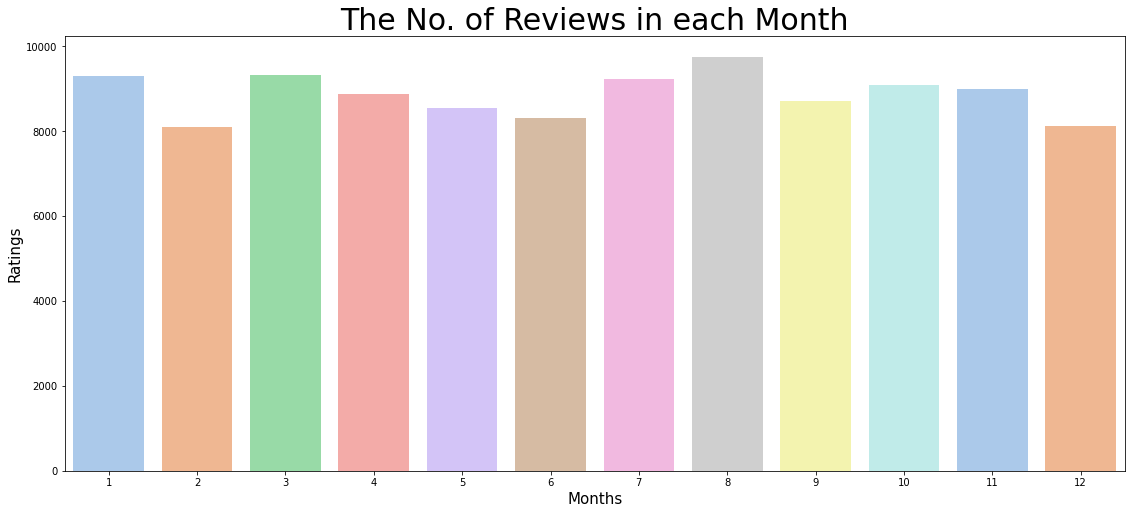

In [14]:
plt.rcParams['figure.figsize'] = (19, 8)
sns.countplot(df['month'], palette ='pastel')
plt.title('The No. of Reviews in each Month', fontsize = 30)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Ratings', fontsize = 15)
plt.show()

In [15]:
df["rating"].value_counts()

10    33736
9     18144
1     14460
8     12174
7      6112
5      5344
2      4616
3      4370
6      4180
4      3264
Name: rating, dtype: int64

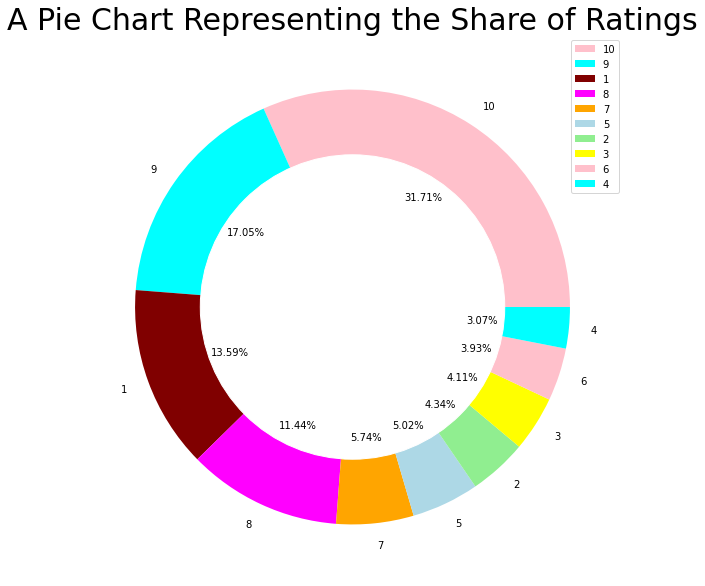

In [16]:
colors = ['pink', 'cyan', 'maroon',  'magenta', 'orange', 'lightblue', 'lightgreen', 'yellow']
labels = "10", "9", "1", "8", "7", "5","2","3","6", "4"
size=[33736, 18144, 14460, 12174,  6112,  5344,  4616,  4370,  4180,
        3264]
my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%')
plt.axis('off')
plt.title('A Pie Chart Representing the Share of Ratings', fontsize = 30)
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.legend()
plt.show()

In [17]:
stemmer=PorterStemmer()
lemmatizer = WordNetLemmatizer() 
stop_words=stopwords.words("english")
sentence_filter_stemming=[]
sentence_filter_Lemmatization=[]
final_sentence_stemming=[]
final_sentence_lemmatize=[]
#Removing noise, such as special characters and punctuations
df['Cleaned_Reviews'] = df['review'].str.replace(r"\W", " ").str.strip()#To remove special characters and punctuations
df['Cleaned_Reviews']= df['Cleaned_Reviews'].str.replace(r'\d+',"")#To remove Numbers
for a in df['Cleaned_Reviews']:
    splitting_words=word_tokenize(a)
    for b in splitting_words:
        if b not in stop_words:#Removing Stop Words
            lemmatization_words=lemmatizer.lemmatize(b.lower())#Lemmatization
            sentence_filter_Lemmatization.append(lemmatization_words)
    final_sentence_lemmatize.append(' '.join(sentence_filter_Lemmatization))
    sentence_filter_Lemmatization.clear()
df['Lemmatization']=pd.DataFrame(final_sentence_lemmatize)
df


,uniqueID,drugName,condition,review,rating,date,usefulCount,Year,month,day,Cleaned_Reviews,Lemmatization
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,2012-02-28,22,2012,2,28,I ve tried a few antidepressants over the ye...,i tried antidepressant year citalopram fluoxet...
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,2009-05-17,17,2009,5,17,My son has Crohn s disease and has done very...,my son crohn disease done well asacol he compl...
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,2017-09-29,3,2017,9,29,Quick reduction of symptoms,quick reduction symptom
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,2017-03-05,35,2017,3,5,Contrave combines drugs that were used for alc...,contrave combine drug used alcohol smoking opi...
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,2015-10-22,4,2015,10,22,I have been on this birth control for one cycl...,i birth control one cycle after reading review...
...,...,...,...,...,...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,2014-09-13,43,2014,9,13,I have taken Tamoxifen for years Side effect...,i androgel two month i say best i felt last ye...
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,2016-10-08,11,2016,10,8,I ve been taking Lexapro escitaploprgram s...,for year i i ravenous hunger low blood sugar c...
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,2010-11-15,7,2010,11,15,I m married years old and I have no kids ...,so much better oxycontin osteoarthritis s i jo...
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,2011-11-28,20,2011,11,28,I was prescribed Nucynta for severe neck shoul...,i taking lexapro year seems help lot social an...


In [19]:

def sentiment(review):
    # Sentiment polarity of the reviews
    pol = []
    for i in review:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol

In [20]:
df['sentiment'] = sentiment(df["Cleaned_Reviews"])

In [21]:

df['sentiment_final'] = df['sentiment'].apply(lambda x: math.ceil(x*10))

In [22]:
df.loc[(df['sentiment_final'] == -10) | (df['sentiment_final'] == -9) , 'updated_sentiment'] = 1
df.loc[(df['sentiment_final'] == -8) | (df['sentiment_final'] == -7) , 'updated_sentiment'] = 2
df.loc[(df['sentiment_final'] == -6) | (df['sentiment_final'] == -5) , 'updated_sentiment'] = 3
df.loc[(df['sentiment_final'] == -4) | (df['sentiment_final'] == -3) , 'updated_sentiment'] = 4
df.loc[(df['sentiment_final'] == -2) | (df['sentiment_final'] == -1) | (df['sentiment_final'] == 0) , 'updated_sentiment'] = 5
df.loc[(df['sentiment_final'] == 0) | (df['sentiment_final'] == 1) | (df['sentiment_final'] == 2) , 'updated_sentiment'] = 6
df.loc[(df['sentiment_final'] == 3) | (df['sentiment_final'] == 4) , 'updated_sentiment'] = 7
df.loc[(df['sentiment_final'] == 5) | (df['sentiment_final'] == 6) , 'updated_sentiment'] = 8
df.loc[(df['sentiment_final'] == 7) | (df['sentiment_final'] == 8) , 'updated_sentiment'] = 9
df.loc[(df['sentiment_final'] == 9) | (df['sentiment_final'] == 10) , 'updated_sentiment'] = 10

In [23]:
df = df.rename(columns={'updated_sentiment':'Sentiment'})
df = df.drop(columns=['sentiment'])

In [33]:
df

,uniqueID,drugName,condition,review,rating,date,usefulCount,Year,month,day,Cleaned_Reviews,Lemmatization,sentiment_final,Sentiment
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,2012-02-28,22,2012,2,28,I ve tried a few antidepressants over the ye...,i tried antidepressant year citalopram fluoxet...,0,6.0
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,2009-05-17,17,2009,5,17,My son has Crohn s disease and has done very...,my son crohn disease done well asacol he compl...,6,8.0
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,2017-09-29,3,2017,9,29,Quick reduction of symptoms,quick reduction symptom,4,7.0
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,2017-03-05,35,2017,3,5,Contrave combines drugs that were used for alc...,contrave combine drug used alcohol smoking opi...,2,6.0
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,2015-10-22,4,2015,10,22,I have been on this birth control for one cycl...,i birth control one cycle after reading review...,3,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,2014-09-13,43,2014,9,13,I have taken Tamoxifen for years Side effect...,i androgel two month i say best i felt last ye...,1,6.0
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,2016-10-08,11,2016,10,8,I ve been taking Lexapro escitaploprgram s...,for year i i ravenous hunger low blood sugar c...,2,6.0
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,2010-11-15,7,2010,11,15,I m married years old and I have no kids ...,so much better oxycontin osteoarthritis s i jo...,0,6.0
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,2011-11-28,20,2011,11,28,I was prescribed Nucynta for severe neck shoul...,i taking lexapro year seems help lot social an...,0,6.0


In [32]:
df.to_csv("sentiment_data.csv")

In [24]:
df["Lemmatization"]

0        i tried antidepressant year citalopram fluoxet...
1        my son crohn disease done well asacol he compl...
2                                  quick reduction symptom
3        contrave combine drug used alcohol smoking opi...
4        i birth control one cycle after reading review...
                               ...                        
53761    i androgel two month i say best i felt last ye...
53762    for year i i ravenous hunger low blood sugar c...
53763    so much better oxycontin osteoarthritis s i jo...
53764    i taking lexapro year seems help lot social an...
53765                                       fast effective
Name: Lemmatization, Length: 106400, dtype: object

**Emotions Capturing Basing on Drug Review**

In [26]:
emotions_df = pd.read_csv("/content/sample_data/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt",  names=["word", "emotion", "association"], sep='\t')
emotions_words = emotions_df.pivot(index='word',columns='emotion',values='association').reset_index()

In [55]:
df_sample=df.sample(n=10000)
new_df=df_sample.copy()

In [56]:
new_df=new_df.reset_index().iloc[:,1:]

In [57]:
emotions = emotions_words.columns.drop('word')
emo_df = pd.DataFrame(0, index=new_df.index, columns=emotions)
i=0
for a in df_sample['Lemmatization']:
  splitting_words=word_tokenize(a)
  for word in splitting_words:
    emo_score = emotions_words[emotions_words.word == word]
    if not emo_score.empty:
      for emotion in list(emotions):
        emo_df.at[i, emotion] += emo_score[emotion]
  i=i+1

In [58]:
new_df = pd.concat([new_df, emo_df], axis=1)

In [61]:
new_df.to_csv("Sentiment_Emotions.csv")

In [100]:
df=pd.read_csv("/content/Sentiment_Emotions.csv")
df=df[df["drugName"]=="Magnesium sulfate / potassium sulfate / sodium sulfate"].sort_values(by="usefulCount", ascending=False).iloc[0,15:25]


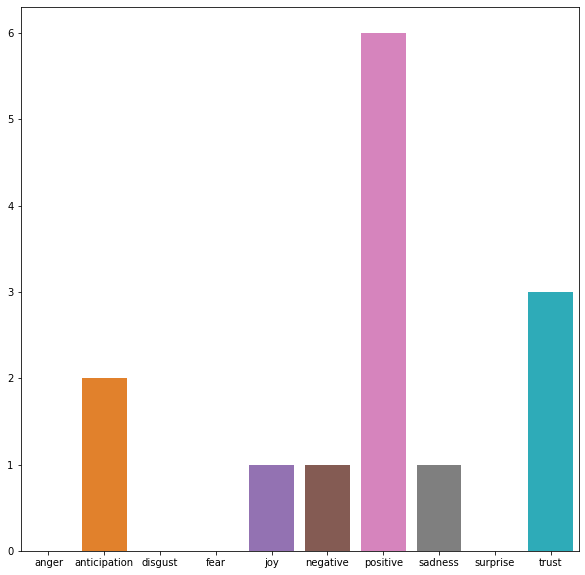

In [101]:
sns.barplot(df.index,df.values)

**Drug Prediction Based on Ranking**

In [36]:
input_condition = 'Birth Control'
cond_filtered = df[df['condition'] == input_condition]
cond_filtered = cond_filtered.groupby(['condition','drugName']).agg('mean').sort_values(['Sentiment'],ascending=False)
cond_filtered=cond_filtered.reset_index()

In [37]:
cond_filtered["drugName"].head(5)

0       Zovia 1 / 50
1           Altavera
2           Amethyst
3    Low-Ogestrel-21
4       Ortho Cyclen
Name: drugName, dtype: object

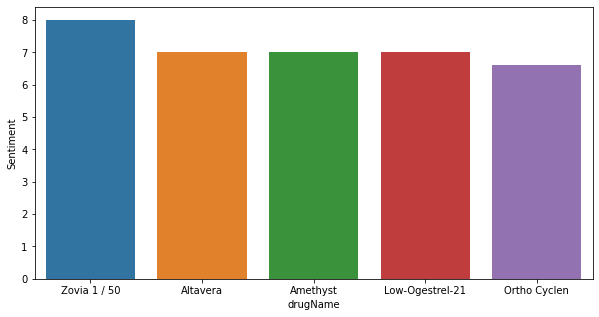

In [45]:
plt.figure(figsize=(10,5))
sns.barplot(cond_filtered["drugName"].head(5),cond_filtered["Sentiment"].head(5))